In [1]:

from networkit import *
import glob
from tqdm import tqdm_notebook
import networkit as nx
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime
import pickle
from glob import glob
from datetime import datetime


In [2]:
nx.setNumberOfThreads(20)
nx.setLogLevel("TRACE")

In [3]:
with open('../user_details.json') as fp:
    dict_users_original = json.load(fp)
with open('../Networks/interaction_network_per_month.json', 'rb') as fp:
    data = pickle.load(fp)
with open('../Networks/kcore_temportal.json', 'rb') as fp:
    monthwise_kcore_dict = pickle.load(fp)  
with open('../Networks/map_dict_kcore.json', 'rb') as fp:
    map_dict_kcore = pickle.load(fp)  
    
df_user_label=pd.read_csv('../Results/user_labelling.csv')
all_normal_dict={key:1 for key in list(df_user_label[df_user_label['label']=='normal']['user_key'])}
df_matched=pd.read_csv('../Results/matched.csv')



In [4]:
with open('../Networks/interaction_network_per_month.json', 'rb') as fp:
    interaction_data = pickle.load(fp)


In [5]:
with open('../Networks/betweeness_centrality.json', 'rb') as fp:
    betweenness_data = pickle.load(fp)
    
with open('../Networks/eigen_vector_centrality.json', 'rb') as fp:
    eigen_data = pickle.load(fp)


In [6]:
df_betweenness=pd.DataFrame(betweenness_data.values())

In [7]:
df_users_timeline=pd.read_csv('../Results/kcore_analysis.csv')


In [8]:
file = '../../../../GAB_data/FollowersFollowing/Follow_Following_June2018.json'

In [9]:
threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}
dict_labels={'hatespeech':2,'fearspeech':1,'normal':0}
reverse_dict_labels={dict_labels[key]:key for key in dict_labels.keys()}

In [10]:
dict_users={}
dict_users_ambi={}
files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))


for file in tqdm_notebook(files,total=len(files)):
    
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)
    
    if('predicted_probab' not in Gab_keyword_match[1].keys()):
        continue
    for element in Gab_keyword_match:
        
        
        try:
            dt = datetime.fromisoformat(element['post_create_time'])
            key_new=str(dt.month)+'/'+str(dt.year)
        except KeyError:
            continue

    
        
        labels=[]
        for i in range(len(element['predicted_probab'])):
            if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                labels.append(reverse_dict_labels[i])
        
        labels_ambi=[]
        for i in range(len(element['predicted_probab'])):
            if(element['predicted_probab'][i]>0.5):
                labels_ambi.append(reverse_dict_labels[i])
        
        
        try:
            for label in labels:
                dict_users[element['username']][label]+=1
            dict_users[element['username']]['total']+=1
        except KeyError:
            try:
                dict_users[element['username']]={'fearspeech':0,'hatespeech':0,'normal':0,'total':0}
                for label in labels:
                    dict_users[element['username']][label]+=1
                dict_users[element['username']]['total']+=1

            except KeyError:
                pass
#         try:
#             for label in labels:
#                 dict_users_ambi[element['username']][label]+=1
#             dict_users_ambi[element['username']]['total']+=1
#         except KeyError:
#             dict_users_ambi[element['username']]={'fearspeech':0,'hatespeech':0,'normal':0,'total':0}
#             for label in labels:
#                 dict_users_ambi[element['username']][label]+=1
#             dict_users_ambi[element['username']]['total']+=1

            

<ipython-input-10-087242fa3de8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(files,total=len(files)):


  0%|          | 0/212 [00:00<?, ?it/s]

In [11]:
len(dict_users)

172917

In [12]:
dict_users_filter={}
max_fear=0
max_hate=0
for key in dict_users.keys():
    user=dict_users[key]
    total=user['fearspeech']+user['hatespeech']
    
    if(user['fearspeech']>max_fear):
        max_fear=user['fearspeech']
    
    if(user['hatespeech']>max_hate):
        max_hate=user['hatespeech']
    
    if(total>=10):
        dict_users_filter[key]=user
        dict_users_filter[key]['name']=key


In [13]:
df_final_users=pd.DataFrame(dict_users_filter).transpose()

In [14]:
df_final_users

,fearspeech,hatespeech,normal,total,name
radiofan2,47,26,1716,2287,radiofan2
kaser100,306,42,4862,7319,kaser100
DeplorableRick,18,19,760,1241,DeplorableRick
kingdomMan,89,4,1172,1969,kingdomMan
Whicket,490,108,16161,21862,Whicket
...,...,...,...,...,...
WeAreAllTommyRobinson,8,2,9,45,WeAreAllTommyRobinson
Luther2,7,23,8,62,Luther2
anhero23,3,10,74,157,anhero23
PewDieNazi,0,15,12,31,PewDieNazi


In [ ]:
df_final_users.to_csv('../Results/user_distribution.csv',index=False)

### Final analysis

In [15]:
list_bd=[]
list_ev=[]
list_followers=[]
list_following=[]


for index,row in df_final_users.iterrows():
    list_bd.append(betweenness_data[index])
    list_ev.append(eigen_data[index])
    list_following.append(dict_users_original[index]['followers_count'])
    list_followers.append(dict_users_original[index]['followings_count'])


In [ ]:
# df_final_users['fearspeech']=df_final_users['fearspeech']/df_final_users['total']
# df_final_users['hatespeech']=df_final_users['hatespeech']/df_final_users['total']


In [16]:
df_final_users

,fearspeech,hatespeech,normal,total,name
radiofan2,47,26,1716,2287,radiofan2
kaser100,306,42,4862,7319,kaser100
DeplorableRick,18,19,760,1241,DeplorableRick
kingdomMan,89,4,1172,1969,kingdomMan
Whicket,490,108,16161,21862,Whicket
...,...,...,...,...,...
WeAreAllTommyRobinson,8,2,9,45,WeAreAllTommyRobinson
Luther2,7,23,8,62,Luther2
anhero23,3,10,74,157,anhero23
PewDieNazi,0,15,12,31,PewDieNazi


In [17]:
df_final_users['eigen_vector']=list_ev
df_final_users['betweeness']=list_bd
df_final_users['followers']=list_followers
df_final_users['following']=list_following

In [18]:
time_to_reach_list=[]
velocity=[]
for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):
    try:
        time=df_users_timeline[df_users_timeline['user_key']==index]['time_to_reach'].iloc[0]
        vel=df_users_timeline[df_users_timeline['user_key']==index]['velocity'].iloc[0]
    except IndexError:
        time=-1
        vel=-1
    time_to_reach_list.append(time)
    velocity.append(vel)
    

<ipython-input-18-f1876a20756d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):


  0%|          | 0/9245 [00:00<?, ?it/s]

In [19]:
following_follower_ratio=[]
for index,row in df_90.iterrows():
    if(row['followers']>10):
        following_follower_ratio.append([row['name'],row['following']/row['followers']])

NameError: name 'df_90' is not defined

In [ ]:
count=1
users_to_remove=[]
for ratio in following_follower_ratio:
    if(ratio[1]>10):
        users_to_remove.append(ratio[0])
        count+=1

count

In [ ]:
df_90.drop(users_to_remove, inplace = True )


In [84]:
df_final_users['time_to_reach']=time_to_reach_list
df_final_users['velocity']=velocity

In [85]:
df_final_users.head()

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers,normal_reposters,total_normal_reposts,normal_mentions,total_normal_mentions,normal_repliers,total_normal_replies,time_to_reach,velocity
radiofan2,47,26,1716,2287,radiofan2,0.006149,0.000000,967,1103,0.205802,5,6,5,6,5,6,0,0.0
kaser100,306,42,4862,7319,kaser100,0.015517,0.000055,2082,1904,0.247899,36,51,36,51,36,51,1,1.0
DeplorableRick,18,19,760,1241,DeplorableRick,0.005291,0.000000,800,978,0.175869,4,8,4,8,4,8,0,0.0
kingdomMan,89,4,1172,1969,kingdomMan,0.002564,0.000000,536,1043,0.241611,28,35,28,35,28,35,1,1.0
Whicket,490,108,16161,21862,Whicket,0.015630,0.000041,2059,1767,0.255801,10,12,10,12,10,12,0,0.0


### Follower distribution

In [20]:
import networkx as nx
 

def get_graph_features(file):
    map_dict={}
    follower_dict={}
    count=0
    with open(file) as fp:
        dict_follower_followship=json.load(fp)

    for user_key in tqdm_notebook(dict_follower_followship.keys()):
        try:
            temp=map_dict[user_key]
        except KeyError:
            map_dict[user_key]=count
            count+=1



        for user_follower in dict_follower_followship[user_key]['follower']:
            try:
                temp=map_dict[user_follower]
            except KeyError:
                map_dict[user_follower]=count
                count+=1

            try:
                follower_dict[map_dict[user_key]][map_dict[user_follower]]=1
            except KeyError:
                follower_dict[map_dict[user_key]]={}
                follower_dict[map_dict[user_key]][map_dict[user_follower]]=1

    reverse_map_dict={value:key for key,value in map_dict.items()}

    G = nx.DiGraph()
    for user_key in follower_dict.keys():
        for follower_key in follower_dict[user_key].keys():
            G.add_edge(user_key, follower_key)
            
    return G, map_dict, reverse_map_dict



In [22]:
file='../../../../GAB_data/FollowersFollowing/Follow_Following_June2018.json'
G, map_dict, reverse_map_dict=get_graph_features(file)

<ipython-input-20-27f14975ef1c>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_key in tqdm_notebook(dict_follower_followship.keys()):


  0%|          | 0/172929 [00:00<?, ?it/s]

In [32]:
df_final_users

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers
radiofan2,47,26,1716,2287,radiofan2,6.149054e-03,0.000000,967,1103,-1
kaser100,306,42,4862,7319,kaser100,1.551704e-02,0.000055,2082,1904,-1
DeplorableRick,18,19,760,1241,DeplorableRick,5.291231e-03,0.000000,800,978,-1
kingdomMan,89,4,1172,1969,kingdomMan,2.564034e-03,0.000000,536,1043,-1
Whicket,490,108,16161,21862,Whicket,1.562968e-02,0.000041,2059,1767,-1
...,...,...,...,...,...,...,...,...,...,...
WeAreAllTommyRobinson,8,2,9,45,WeAreAllTommyRobinson,0.000000e+00,0.000000,0,21,-1
Luther2,7,23,8,62,Luther2,0.000000e+00,0.000000,0,5,-1
anhero23,3,10,74,157,anhero23,1.630122e-03,0.000000,185,256,-1
PewDieNazi,0,15,12,31,PewDieNazi,3.201372e-05,0.000014,6,5,-1


In [36]:
normal_followers=[]
for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):
    try:
        succesors=list(G.successors(map_dict[index]))
        normal=0
        total=0
        for suc in succesors:
            user_suc_name=reverse_map_dict[suc]
            try:
                temp=all_normal_dict[user_suc_name]
                normal+=1
            except KeyError:
                pass
            total+=1
        if(total>0):
            normal_followers.append(normal/total)
        else:
            normal_followers.append(0)
    except (nx.NetworkXError, KeyError) as e:
        normal_followers.append(-1)
        pass
        

<ipython-input-36-2d3e37bbc55c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):


  0%|          | 0/9245 [00:00<?, ?it/s]

In [37]:
df_final_users['normal_followers']=normal_followers

In [38]:
df_final_users

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers
radiofan2,47,26,1716,2287,radiofan2,6.149054e-03,0.000000,967,1103,0.205802
kaser100,306,42,4862,7319,kaser100,1.551704e-02,0.000055,2082,1904,0.247899
DeplorableRick,18,19,760,1241,DeplorableRick,5.291231e-03,0.000000,800,978,0.175869
kingdomMan,89,4,1172,1969,kingdomMan,2.564034e-03,0.000000,536,1043,0.241611
Whicket,490,108,16161,21862,Whicket,1.562968e-02,0.000041,2059,1767,0.255801
...,...,...,...,...,...,...,...,...,...,...
WeAreAllTommyRobinson,8,2,9,45,WeAreAllTommyRobinson,0.000000e+00,0.000000,0,21,0.333333
Luther2,7,23,8,62,Luther2,0.000000e+00,0.000000,0,5,0.200000
anhero23,3,10,74,157,anhero23,1.630122e-03,0.000000,185,256,0.109375
PewDieNazi,0,15,12,31,PewDieNazi,3.201372e-05,0.000014,6,5,0.000000


### Interactions 

In [157]:
interaction_dict={}
interaction_key='replies'
for month_year in tqdm_notebook(interaction_data.keys()):
    user_data=interaction_data[month_year]
    for key in user_data.keys():
        try:
            interaction_dict[key[0]][key[1]]+=user_data[key][interaction_key]
        except KeyError:
            try:
                interaction_dict[key[0]][key[1]]=user_data[key][interaction_key]
            except KeyError:
                interaction_dict[key[0]]={}
                interaction_dict[key[0]][key[1]]=user_data[key][interaction_key]

<ipython-input-157-f8a452d33faa>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for month_year in tqdm_notebook(interaction_data.keys()):


  0%|          | 0/22 [00:00<?, ?it/s]

In [122]:
user_data[key]

{'reposts': 1, 'replies': 0, 'mentions': 0}

In [40]:
edges_count=0
for month_year in tqdm_notebook(interaction_data.keys()):
    user_data=interaction_data[month_year]
    for key in user_data.keys():
        if(user_data[key]['replies']>0):
            edges_count+=1
        if(user_data[key]['reposts']>0):
            edges_count+=1
        if(user_data[key]['mentions']>0):
            edges_count+=1
        
        
        

<ipython-input-40-c792ceafd523>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for month_year in tqdm_notebook(interaction_data.keys()):


  0%|          | 0/22 [00:00<?, ?it/s]

In [41]:
edges_count

8061653

In [158]:
import networkx
G = networkx.DiGraph()
for user_key in tqdm_notebook(interaction_dict.keys()):
    for inter_user_key in interaction_dict[user_key].keys():
        if(user_key==inter_user_key):
            continue
        if(interaction_dict[user_key][inter_user_key]>0):
            #For reply. TUPLE (A,B) Means A is replying TO B's post
            G.add_edge(inter_user_key,user_key,weight=interaction_dict[user_key][inter_user_key])
            #For reposts, TUPLE (A,B) Means B is reposting A's post
            #G.add_edge(user_key,inter_user_key,weight=interaction_dict[user_key][inter_user_key])
            #For mentions, TUPLE (A,B)  Means A is mentioning B in the post
            #G.add_edge(user_key,inter_user_key,weight=interaction_dict[user_key][inter_user_key])
            
            
            

<ipython-input-158-02080fe0040a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_key in tqdm_notebook(interaction_dict.keys()):


  0%|          | 0/109202 [00:00<?, ?it/s]

In [159]:
len(G.edges())

2786607

In [160]:
normal_reposters=[]
total_normal_reposts=[]
for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):
    try:
        succesors=list(G.successors(index))
        normal=0
        total_normal=0
        for user_suc_name in succesors:
            weight=G[index][user_suc_name]["weight"]
            try:
                temp=all_normal_dict[user_suc_name]
                normal+=weight
                total_normal+=1
            except KeyError:
                pass
            
        normal_reposters.append(total_normal)
        total_normal_reposts.append(normal)
            
    
    except (nx.NetworkXError, KeyError) as e:
        total_normal_reposts.append(-1)
        normal_reposters.append(-1)
        pass
    


<ipython-input-160-3c9b504a8e2d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index,row in tqdm_notebook(df_final_users.iterrows(),total=len(df_final_users)):


  0%|          | 0/9245 [00:00<?, ?it/s]

In [142]:
df_final_users['normal_reposters']=normal_reposters
df_final_users['total_normal_reposts']=total_normal_reposts

In [156]:
df_final_users['normal_mentions']=normal_reposters
df_final_users['total_normal_mentions']=total_normal_reposts


In [161]:
df_final_users['normal_repliers']=normal_reposters
df_final_users['total_normal_replies']=total_normal_reposts


In [48]:
df_final_users.columns

Index(['fearspeech', 'hatespeech', 'normal', 'total', 'name', 'eigen_vector',
       'betweeness', 'followers', 'following', 'normal_followers',
       'normal_reposters', 'total_normal_reposts', 'normal_mentions',
       'total_normal_mentions', 'normal_repliers', 'total_normal_replies'],
      dtype='object')

In [170]:
df_final_users

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers,normal_reposters,total_normal_reposts,normal_mentions,total_normal_mentions,normal_repliers,total_normal_replies,time_to_reach,velocity
radiofan2,47,26,1716,2287,radiofan2,6.149054e-03,0.000000,967,1103,0.205802,-1,-1,15,23,5,6,0,0.000000
kaser100,306,42,4862,7319,kaser100,1.551704e-02,0.000055,2082,1904,0.247899,0,0,35,52,36,51,1,1.000000
DeplorableRick,18,19,760,1241,DeplorableRick,5.291231e-03,0.000000,800,978,0.175869,-1,-1,11,16,4,8,0,0.000000
kingdomMan,89,4,1172,1969,kingdomMan,2.564034e-03,0.000000,536,1043,0.241611,2,2,22,36,28,35,1,1.000000
Whicket,490,108,16161,21862,Whicket,1.562968e-02,0.000041,2059,1767,0.255801,55,71,23,39,10,12,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WeAreAllTommyRobinson,8,2,9,45,WeAreAllTommyRobinson,0.000000e+00,0.000000,0,21,0.333333,0,0,0,0,0,0,-1,2.500000
Luther2,7,23,8,62,Luther2,0.000000e+00,0.000000,0,5,0.200000,0,0,0,0,0,0,-1,3.500000
anhero23,3,10,74,157,anhero23,1.630122e-03,0.000000,185,256,0.109375,0,0,0,0,1,1,0,0.000000
PewDieNazi,0,15,12,31,PewDieNazi,3.201372e-05,0.000014,6,5,0.000000,0,0,0,0,0,0,-1,0.714286


### Stats model

In [ ]:
import statsmodels.api as sm
import numpy as np

In [ ]:
str_column='normal_followers'
linear_model_str=str_column+" ~fearspeech+hatespeech+total"

df_final_users_temp=df_final_users[['fearspeech','hatespeech','total',str_column]]
#normalized_df=(df_final_users_temp-df_final_users_temp.min())/(df_final_users_temp.max()-df_final_users_temp.min())
print(np.mean(df_final_users[str_column]))
model_lin = sm.OLS.from_formula(linear_model_str,data=df_final_users_temp)
result_lin = model_lin.fit()
result_lin.summary()

In [ ]:
str_column='normal_followers'
linear_model_str=str_column+" ~ fearspeech+hatespeech+total"
df_final_users_temp=df_final_users[df_final_users[str_column]!=-1]
print(np.mean(df_final_users_temp[str_column]),len(df_final_users_temp))
#model_lin = sm.OLS.from_formula(linear_model_str,data=df_final_users_temp[['fearspeech','hatespeech','total',str_column]])
model_lin = sm.GLM.from_formula(linear_model_str,data=df_final_users_temp[['fearspeech','hatespeech','total',str_column]],family=sm.families.NegativeBinomial())
result_lin = model_lin.fit()
result_lin.summary()

## Interaction network

In [49]:
import numpy as np

In [50]:
np.var(df_final_users['followers'])

14859364.270243034

In [162]:
df_final_users.fearspeech.quantile(0.9)

93.0

In [163]:
df_final_users.hatespeech.quantile(0.9)

150.0

In [164]:
df_90_hate=df_final_users[(df_final_users['hatespeech']>=150) & (df_final_users['fearspeech']<93)]
df_90_hate['label']='H'

<ipython-input-164-8ffde5925a77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_hate['label']='H'


In [165]:
df_90_fear=df_final_users[(df_final_users['hatespeech']<150) & (df_final_users['fearspeech']>=93)]
df_90_fear['label']='F'

<ipython-input-165-c917ec06f2db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_fear['label']='F'


In [166]:
df_90_hybrid=df_final_users[(df_final_users['hatespeech']>150) & (df_final_users['fearspeech']>93)]
df_90_hybrid['label']='B'

<ipython-input-166-797d88ae79ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_hybrid['label']='B'


In [171]:
df_90=pd.concat([df_90_fear,df_90_hate,df_90_hybrid],ignore_index=False)

In [172]:
print(len(df_90_fear),len(df_90_hate),len(df_90_hybrid))

483 479 445


In [173]:
np.sum(list(df_90_hate.fearspeech))

18965

In [89]:
df_90[df_90['label']=='F']['total'].sum()

2623908

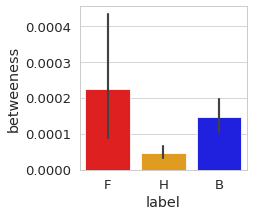

In [61]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="betweeness", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/betweenness_centrality.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

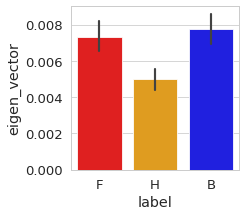

In [68]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="eigen_vector", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/eigen_vector_centrality.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

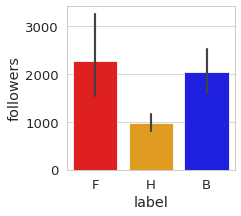

In [69]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="followers", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/followers.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

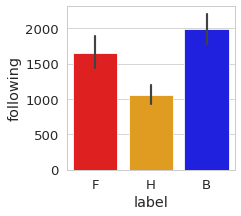

In [70]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="following", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/followings.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

In [ ]:
df_90.to_csv('../Results/top_10_percentile.csv',index=False)

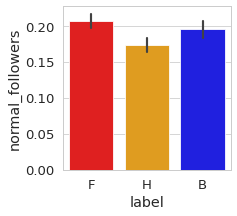

In [71]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="normal_followers", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/normal_followers.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

In [76]:
df_90['normal_followers']=df_90['normal_followers']/(df_90['followers']+1e-15)

In [75]:
df_90['normal_followers']

kaser100               5.718915e-08
Whicket                6.033776e-08
ROYALMRBADNEWS         6.923662e-08
HotpageNews                     inf
bogthing               2.449607e-08
                           ...     
roonyroo               1.647553e-06
WW-OPS                 4.077670e-05
NoraLisa               3.864205e-07
bro333                 9.756098e-04
NoMoreWarsForIsrael    9.210384e-06
Name: normal_followers, Length: 1407, dtype: float64

In [78]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
colours=data['data'][0]['node']['color']

def get_sources_target_val(df):
    dict_tuples={}
    for i in range(0,len(months_list)-1):
        key=tuple([months_list[i],months_list[i+1]])
        dict_tuples[key]={}
        wide_df = df[[months_list[i],months_list[i+1],'freq']].groupby([months_list[i],months_list[i+1]], as_index=False).sum()
        columns=list(wide_df.columns)[0:3]
        for index,row in wide_df.iterrows():
            dict_tuples[key][tuple([row[columns[0]],row[columns[1]]])]=row['freq']
    
    sources=[]
    target=[]
    values=[]
    colour_values=[]
    i=0
    for key in dict_tuples.keys():
        for element in sorted(list(dict_tuples[key].keys())):
            print(element)
            source_index=label[key[0]+'-'+str(element[0])]
            target_index=label[key[1]+'-'+str(element[1])]
#             source_index=key[0]+'-'+str(element[0])
#             target_index=key[1]+'-'+str(element[1])

            value=dict_tuples[key][element]
            
            
            sources.append(source_index)
            target.append(target_index)
            values.append(value)
            
            if((element[0] in [0,1,2,99]) and (element[1] in [0,1,2,99])):
                if(key[0]=='8/17'):
                    colour_values.append(colours[i].replace("0.8", str(0.8)))
                else:
                    colour_values.append(colours[i].replace("0.8", str(0.4)))
            else:
                colour_values.append("rgba(0, 0, 0, 0.05)")
        i+=1
    return sources,target,values,colour_values,dict_tuples



def get_plotly_figure(sources,target,values,colour_values,labels_modified):
    layout = go.Layout(
      margin=go.layout.Margin(
            l=1, #left margin
            r=1, #right margin
            b=10, #bottom margin
            t=2  #top margin
        )
    )


    fig = go.Figure(data=[go.Sankey(
        arrangement = "snap",
        node = dict(
          pad = 15,
          thickness = 2,
          line = dict(color = "black", width = 0.2),
          label = labels_modified,
          color='black'
        ),
        link = dict(
          source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = values,
          color = colours_value
      ))],layout=layout)
    return fig

In [79]:
import pandas as pd
from tqdm import tqdm_notebook
df_users_timeline=pd.read_csv('../Results/kcore_analysis.csv')
df_users_timeline=df_users_timeline.drop(columns=['time_to_reach','velocity'])
#df_users_timeline=df_users_timeline.replace([3,4,5,6,7,8,9],98)
# df_users_timeline['freq']=1

In [80]:
df_users_timeline_fear=df_users_timeline[df_users_timeline['user_key'].isin(list(df_90_fear.index))]
df_users_timeline_hate=df_users_timeline[df_users_timeline['user_key'].isin(list(df_90_hate.index))]

In [81]:
dict_tuples={}
i=8
key=tuple([months_list[i],months_list[i+1]])
dict_tuples[key]={}
wide_df = df_users_timeline_fear[[months_list[i],months_list[i+1],'freq']].groupby([months_list[i],months_list[i+1]], as_index=False).sum()


NameError: name 'months_list' is not defined

In [82]:
months_list=list(df_users_timeline.columns)[2:-1]

label={}
count=0
for month in months_list:
    for i in range(0,10,1):
        label[month+'-'+str(i)]=count
        count+=1        
    label[month+'-'+str(99)]=count
    count+=1

labels_modified=[]
for ele in list(label.keys()):
    if ele.split('-')[1]=='99':
        labels_modified.append('NA')
    else:
        labels_modified.append(ele.split('-')[1])


In [ ]:
sources,target,values,colours_value,dict_tuples=get_sources_target_val(df_users_timeline_fear)
fig = get_plotly_figure(sources,target,values,colours_value,labels_modified)

In [ ]:
fig.write_image("../Results/sankey_fear.pdf")

In [ ]:
sources,target,values,colours_value,dict_tuples=get_sources_target_val(df_users_timeline_hate)
fig = get_plotly_figure(sources,target,values,colours_value,labels_modified)
fig.write_image("../Results/sankey_hate.pdf")

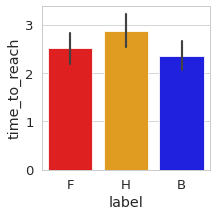

In [96]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="time_to_reach", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/time_to_reach.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

In [87]:
df_90.head()

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers,normal_reposters,total_normal_reposts,normal_mentions,total_normal_mentions,normal_repliers,total_normal_replies,label
kaser100,306,42,4862,7319,kaser100,0.015517,0.000055,2082,1904,2.746837e-11,36,51,36,51,36,51,F
Whicket,490,108,16161,21862,Whicket,0.015630,0.000041,2059,1767,2.930440e-11,10,12,10,12,10,12,F
ROYALMRBADNEWS,138,58,37171,41766,ROYALMRBADNEWS,0.014321,0.000219,2059,1993,3.362633e-11,55,104,55,104,55,104,F
HotpageNews,160,9,40239,43352,HotpageNews,0.000000,0.000000,0,106,inf,9,9,9,9,9,9,F
bogthing,115,53,4710,7848,bogthing,0.015138,0.000137,3455,4203,7.090034e-12,34,42,34,42,34,42,F


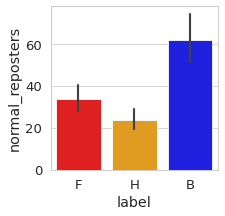

In [167]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="normal_reposters", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/normal_reposters.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

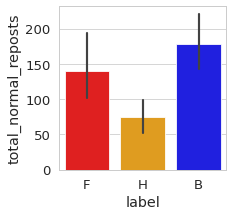

In [174]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="total_normal_reposts", data=df_90, palette=['red','orange','blue'])
plt.show()
#path='../Results/total_normal_reposts.pdf'
#plt.savefig(path,bbox_inches='tight',dpi=400)

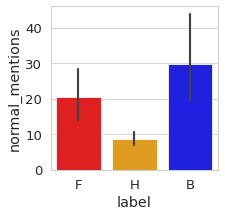

In [175]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="normal_mentions", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/normal_mentions.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

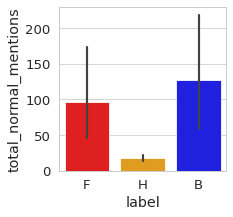

In [176]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="total_normal_mentions", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/total_normal_mentions.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

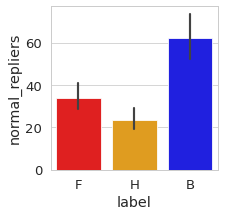

In [177]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="normal_repliers", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/normal_repliers.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

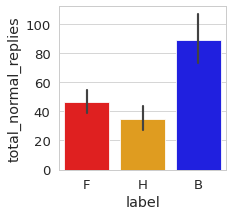

In [178]:
import numpy as np
matplotlib.rcParams['figure.figsize'] = (3, 3)
sns.set(context='paper',style='whitegrid',font_scale=1.5)

# sns.set_theme(style="whitegrid")

# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label",y="total_normal_replies", data=df_90, palette=['red','orange','blue'])
plt.show()
# path='../Results/total_normal_repliers.pdf'
# plt.savefig(path,bbox_inches='tight',dpi=400)

In [62]:
df_90.head()

,fearspeech,hatespeech,normal,total,name,eigen_vector,betweeness,followers,following,normal_followers,normal_reposters,total_normal_reposts,normal_mentions,total_normal_mentions,normal_repliers,total_normal_replies,label
kaser100,306,42,4862,7319,kaser100,0.015517,0.000055,2082,1904,0.247899,36,51,36,51,36,51,F
Whicket,490,108,16161,21862,Whicket,0.015630,0.000041,2059,1767,0.255801,10,12,10,12,10,12,F
ROYALMRBADNEWS,138,58,37171,41766,ROYALMRBADNEWS,0.014321,0.000219,2059,1993,0.293527,55,104,55,104,55,104,F
HotpageNews,160,9,40239,43352,HotpageNews,0.000000,0.000000,0,106,0.292453,9,9,9,9,9,9,F
bogthing,115,53,4710,7848,bogthing,0.015138,0.000137,3455,4203,0.292410,34,42,34,42,34,42,F


In [186]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
seed(1)
column_name='total_normal_replies'

treatment=list(df_90[(df_90['label']=='F') & (df_90[column_name]!=-1)][column_name])
control=list(df_90[(df_90['label']=='B') & (df_90[column_name]!=-1)][column_name])
print("F",np.mean(treatment))
print("B",np.mean(control))

stat, p = mannwhitneyu(treatment, control,alternative='less')
print('Statistics=%.3f, p=%.10f' % (stat, p))

F 46.18840579710145
B 88.6808988764045
Statistics=78657.500, p=0.0000000000


In [64]:
top10user=list(df_90[df_90['label']=='F'].sort_values('total_normal_reposts',ascending=False)[0:10].index)

In [ ]:
import random
def get_samples(users=None,label='fearspeech'):
    threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}
    posts=[]
    files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
    for file in tqdm_notebook(files,total=len(files)):
   
        with open(file, 'rb') as handle:
            Gab_keyword_match = pickle.load(handle)

        if('predicted_probab' not in Gab_keyword_match[1].keys()):
            print("not found")
            continue

        for element in Gab_keyword_match:
            
            post={}
            post['body']=element['post_body']
            labels=[]
    
            for i in range(len(element['predicted_probab'])):
                if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                    labels.append(reverse_dict_labels[i])

            post['labels']=labels
            
            if(label=='normal' and post['labels']==[]):
                if(element['username'] in users):
                    #print(line,labels)
                    posts.append([element['post_body'],'normal',element['like_count'],element['repost_count']])
            
            if(post['labels']==[label]):
                if(element['username'] in users):
#                     #print(line,labels)
                    posts.append([element['post_body'],labels[0],element['like_count'],element['repost_count'],element['reply_count']])
    print(len(posts))
    df=pd.DataFrame(posts, columns=['text','label','like','repost','reply'])
    return df
#     print(len(posts))
#     samples=random.sample(posts,min(len(posts),20))
    
#     for sample in samples:
#         print(sample)
#         print("==============================================")

def get_samples_date(month_start=1,month_end=3,year_start=2017,year_end=2017,label='fearspeech'):
    threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}
    posts=[]
    files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
    for file in tqdm_notebook(files,total=len(files)):
   
        with open(file, 'rb') as handle:
            Gab_keyword_match = pickle.load(handle)

        if('predicted_probab' not in Gab_keyword_match[1].keys()):
            print("not found")
            continue

        for element in Gab_keyword_match:
            flag_add=False
            try:
                dt = datetime.fromisoformat(element['post_create_time'])
                if((dt.month >= month_start and dt.month <= month_end) and (dt.year >= year_start and dt.year <= year_end)):
                    flag_add=True
                else:
                    flag_add=False
#                 key_new=str(dt.month)+'/'+str(dt.year)
            except KeyError:
                continue
            
            
            post={}
            post['body']=element['post_body']
            labels=[]
            
            
            
            for i in range(len(element['predicted_probab'])):
                if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                    labels.append(reverse_dict_labels[i])

            post['labels']=labels
            
            if(label=='normal' and post['labels']==[]):
#                 if(element['username'] in users):
#                     #print(line,labels)
                    if(flag_add):
                        posts.append([element['post_body'],'normal',element['like_count'],element['repost_count']])
            
            if(post['labels']==[label]):
#                 if(element['username'] in users):
#                     #print(line,labels)
                    if(flag_add):
                        posts.append([element['post_body'],labels[0],element['like_count'],element['repost_count'],element['reply_count']])
    print(len(posts))
    df=pd.DataFrame(posts, columns=['text','label','like','repost','reply'])
    return df
#     print(len(posts))
#     samples=random.sample(posts,min(len(posts),20))
    
#     for sample in samples:
#         print(sample)
#         print("==============================================")



In [ ]:
df=get_samples(users=None,label='fearspeech')

In [ ]:
df.sort_values('reply',ascending=False)[0:20]

In [ ]:
df_mentions=get_samples_date(month_start=2,month_end=3,year_start=2018,year_end=2018,label='hatespeech')

In [ ]:
df_mentions_hate=get_samples_date(month_start=2,month_end=3,year_start=2018,year_end=2018,label='hatespeech')

In [ ]:
df_mentions_hate.sort_values('repost',ascending=False)[0:100]

In [ ]:
mentioned_dict_highest={}
for index,row in df_mentions.iterrows():
    text=row['text'].split()
    for word in text:
        mentioned_user=None
        if(len(word.split('@'))>1):
            res = word.split('@')[1]

            # TO AVOID GMAILS
            if(len(res.split('.'))>1):
                if_gmail=res.split('.')[1]
                if(if_gmail!='com'):
                    mentioned_user=res
            else:
                mentioned_user=res
        
        try:
            mentioned_dict_highest[mentioned_user]+=1
        except KeyError:
            mentioned_dict_highest[mentioned_user]=1

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    for ele in list(df_mentions.sample(10).text):
        print(ele)
        print("------------")

In [ ]:
df_hate=get_samples(users=['JaneDoeCountry', 'st3pp3nw0lf', 'Sterangeli5', 'WarRoomShow', 'Lynne75', 'Castelnau', 'Kaybird', 'Pamisue', 'LesaJoy', 'Didizichi'],label='normal')

In [ ]:
df_hate.to_csv('mentioned_nromal.csv')

In [ ]:
pd.set_option('display.max_colwidth', -1)
df.sort_values(by='like',ascending=False).head(20)


In [ ]:
import json
with open('../../../../Gab_Data_old/user_details.json') as fp:
    dict_users_original = json.load(fp)

exfearuser=list(df_90[df_90['label']=='F'].sort_values('total_normal_reposts',ascending=False).index)
def get_mentions(text):
    mentioned_users=[]
    text=text.split()
    for word in text:
        muser=None
        if(len(word.split('@'))>1):
            res = word.split('@')[1]
            # TO AVOID GMAILS
            if(len(res.split('.'))>1):
                if_gmail=res.split('.')[1]
                if(if_gmail!='com'):
                    muser=res
            else:
                muser=res

                    
            if(muser!=None):
                try:
                    temp=dict_users_original[muser]
                    mentioned_users.append(muser)
                except KeyError:
                    continue
    return mentioned_users
        
        
def get_mentioned_users(users=exfearuser,label='fearspeech'):
    threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}
    posts=[]
    mentioned_user_dict={}
    files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
    for file in tqdm_notebook(files,total=len(files)):
   
        with open(file, 'rb') as handle:
            Gab_keyword_match = pickle.load(handle)

        if('predicted_probab' not in Gab_keyword_match[1].keys()):
            print("not found")
            continue

        for element in Gab_keyword_match:
            
            post={}
            post['body']=element['post_body']
            
            
            labels=[]
    
            for i in range(len(element['predicted_probab'])):
                if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                    labels.append(reverse_dict_labels[i])

            post['labels']=labels
            
            if(label=='normal' and post['labels']==[]):
                if(element['username'] in users):
                    #print(line,labels)
                    posts.append([element['post_body'],'normal',element['like_count'],element['repost_count']])
            
            if(post['labels']==[label]):
                if(element['username'] in users):
                    #print(line,labels)
                    
                    mentioned_users=get_mentions(element['post_body'])
                    
                    
                    for element in mentioned_users:
                        try:
                            temp=all_normal_dict[element]
                            try:
                                mentioned_user_dict[element]+=1
                            except KeyError:
                                mentioned_user_dict[element]=1
                        except:
                            pass
                    
                                
                    
                    #posts.append([element['post_body'],labels[0],element['like_count'],element['repost_count']])
    return mentioned_user_dict

### Hybrid Users

In [ ]:
mentioned_user_dict=get_mentioned_users(users=exfearuser,label='fearspeech')

In [ ]:
sorted_dict={k: v for k, v in sorted(mentioned_user_dict.items(), key=lambda item: item[1], reverse=True)[0:10]}
sorted_dict.keys()

In [ ]:
avg_follower=0
avg_following=0 
avg_post=0
for key in sorted_dict.keys():
    if(key=='WarRoomShow'):
        continue
    avg_follower+=dict_users_original[key]['follower_count']/10
    avg_following+=dict_users_original[key]['following_count']/10
    avg_post+=dict_users_original[key]['post_count']/10
    
    

In [ ]:
print(avg_follower,avg_following,avg_post)

### Temporal analysis

In [ ]:
interaction_dict={}
exfearuser=list(df_90[df_90['label']=='F'].sort_values('total_normal_reposts',ascending=False).index)
exhateuser=list(df_90[df_90['label']=='H'].sort_values('total_normal_reposts',ascending=False).index)


def check_condition(users,key,user_data,type_interaction='replies'):
    if(type_interaction=='replies'):
        if(key[1] in users) and (key[0] in all_normal_dict) and user_data[key][type_interaction]>0:
            return True
        else:
            return False
    elif(type_interaction=='reposts'):
        if(key[0] in users) and (key[1] in all_normal_dict) and user_data[key][type_interaction]>0:
            return True
        else:
            return False
    elif(type_interaction=='mentions'):
        if(key[0] in users) and (key[1] in all_normal_dict) and user_data[key][type_interaction]>0:
            return True
        else:
            return False


        
def get_interaction_dict(interaction_data,users,type_interaction):
    interaction_dict={}
    for month_year in tqdm_notebook(interaction_data.keys()):
        user_data=interaction_data[month_year]
        user_replied={}
        for key in user_data.keys():

            if(check_condition(users,key,user_data,type_interaction=type_interaction)):

                try:

                    interaction_dict[month_year]['total_interaction']+=user_data[key][type_interaction]
                    interaction_dict[month_year]['total_users']+=1

                    try:
                        temp=user_replied[key[0]]
                    except KeyError:
                        user_replied[key[0]]=1
                        interaction_dict[month_year]['unique_users']+=1

                except KeyError:
                    interaction_dict[month_year]={}
                    interaction_dict[month_year]['total_interaction']=user_data[key][type_interaction]
                    interaction_dict[month_year]['total_users']=1


                    try:
                        temp=user_replied[key[0]]
                    except KeyError:
                        user_replied[key[0]]=1
                        interaction_dict[month_year]['unique_users']=1
    return interaction_dict

In [ ]:
# interaction_dict_exfear_reply=get_interaction_dict(interaction_data,exfearuser,'replies')
# interaction_dict_exhate_reply=get_interaction_dict(interaction_data,exhateuser,'replies')
# interaction_dict_exfear_repost=get_interaction_dict(interaction_data,exfearuser,'reposts')
# interaction_dict_exhate_repost=get_interaction_dict(interaction_data,exhateuser,'reposts')
interaction_dict_exfear_mention=get_interaction_dict(interaction_data,exfearuser,'mentions')
interaction_dict_exhate_mention=get_interaction_dict(interaction_data,exhateuser,'mentions')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
matplotlib.rcParams['figure.figsize'] = (20, 5)
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.0,"lines.markersize": 10})

x=[]
y=[]

for key in interaction_dict_exfear_mention:
    x.append(key[0:2]+'-'+key[-2:])
    y.append(interaction_dict_exfear_mention[key]['total_interaction']/interaction_dict_exfear_mention[key]['unique_users'])

sns.lineplot(x=x, y=y, color='red')

x=[]
y=[]

for key in interaction_dict_exhate_mention:
    x.append(key[0:2]+'-'+key[-2:])
    y.append(interaction_dict_exhate_mention[key]['total_interaction']/interaction_dict_exhate_mention[key]['unique_users'])

sns.lineplot(x=x, y=y,color='orange')    

In [ ]:
interaction_dict_exhate_mention[key]['unique_users']


### Get fractions replied to by normal users

In [ ]:
files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))

#dict_posts_ids={}
for file in tqdm_notebook(files,total=len(files)):
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)
        
    if('predicted_probab' not in Gab_keyword_match[1].keys()):
        print("not found")
        continue
        
    for element in Gab_keyword_match:
        post={}
        post['body']=element['post_body']


        labels=[]

        for i in range(len(element['predicted_probab'])):
            if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                labels.append(reverse_dict_labels[i])

        post['labels']=labels

        if(label=='normal' and post['labels']==[]):
            pass
#         elif(post['labels']==['fearspeech'] or post['labels']==['hatespeech']):
#             dict_posts_ids[element['id']]['label']=post['labels'][0]
        


        

In [ ]:
len(dict_post_ids)

### Get normal users neighbours

In [ ]:
dict_users_normal={}

for key in dict_users.keys():
    user=dict_users[key]
    total=user['fearspeech']+user['hatespeech']+user['normal']
    total_danger=user['fearspeech']+user['hatespeech']
    if(total>=100 and user['normal']>=10 and total_danger<=10):
        dict_users_normal[key]=user
        dict_users_normal[key]['name']=key

        
df_users_normal=pd.DataFrame(dict_users_normal).transpose()

In [ ]:
df_users_normal

In [ ]:
users_dict={}
count=0
for index,row in tqdm_notebook(df_users_normal.iterrows(),total=len(df_users_normal)):
    try:
        predec=list(G.predecessors(index))
        user_names=[]
        for user in predec:
            user_names.append(user)
        
        users_dict[index]=user_names        
    except (nx.NetworkXError, KeyError):
        count+=1
        pass
print(count)

In [ ]:
user_received_posts={}
    
files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
for file in tqdm_notebook(files,total=len(files)):

                        
                



In [ ]:
len(user_received_posts)

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8

""" Simple demo of using multiprocessing when parsing files """

import sys
import os
import codecs
from multiprocessing import Pool, Process, Queue, cpu_count


def get_file_list(folder):
    """ Returns a list of files inside the <folder> directory """
    file_list = []
    dirs_list = []

    # "Walk" through folder
    for root, dirs, files in os.walk(folder):
        for dir in dirs:
            dirpath = os.path.join(root, dir)
            print(dirpath)

        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if it's file
            if os.path.isfile(filepath):
                file_list.append(filepath)

    return file_list


def parse_file(file_path, nr_lines):
    """ Read first n lines from file """
    user_received_posts={}
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)

        
        for user in tqdm_notebook(users_dict,total=len(users_dict)):
            for element in Gab_keyword_match:
                if(element['username'] in users_dict[user]):
                    labels=[]
                    for i in range(len(element['predicted_probab'])):
                        if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                            labels.append(reverse_dict_labels[i])

                    labels_ambi=[]
                    for i in range(len(element['predicted_probab'])):
                        if(element['predicted_probab'][i]>0.5):
                            labels_ambi.append(reverse_dict_labels[i])

                    if(('fearspeech' in labels) and ('hatespeech' in labels)):
                        dict_add={}
                        pass
                    elif('fearspeech' in labels):
                        dict_add={'id':element['id'], 'label':'fearspeech'}

                    elif('hatespeech' in labels):
                        dict_add={'id':element['id'], 'label':'hatespeech'}
                    else:
                        if(('fearspeech' in labels_ambi) or ('hatespeech' in labels_ambi)):
                            dict_add={}
                            pass
                        else:
                            dict_add={'id':element['id'], 'label':'normal'}

                    if(dict_add!={}):
                        try:
                            user_received_posts[user].append(dict_add)
                        except KeyError:
                            user_received_posts[user]=[]
                            user_received_posts[user].append(dict_add)

    print(file_path,"done")
    return user_received_posts


def process_files(file_list, q):
    """ Proprocess every file in <file_list> and call parse_file() """
    results = []
    try:
        for f in file_list:
            results.append(parse_file(f, 3))
    except:
        q.put([])
        raise

    # Put results into queue
    q.put(results)


def parallelize_parsing(file_list):

    cpu_cores = cpu_count()
    q = Queue()
    procs = []

    # Split the input file list into sublists according to the number
    # of the available CPU cores
    for i in range(0, cpu_cores):
        sub_list = [file_list[j] for j in range(0, len(file_list)) if j % cpu_cores == i]

        if len(sub_list) > 0:
            p = Process(target=process_files, args=([sub_list, q]))
            p.start()
            procs.append(p)

    # Collect the results
    all_results = []
    for i in range(0, len(procs)):
        all_results.append(q.get())

    return results

In [ ]:
# Get list of file paths
file_list = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
# print(file_list)
results=parallelize_parsing(file_list)

In [ ]:
del user_received_posts